# A Better Sort of Yelp Photos: 
### Notebook 2: Image Classification Using A Convolutional Neural Net From Scratch

##### The basic CNN architecture and code for this notebook were patterned after the TensorFlow Author's tutorial found here:  [Tensor Flow Tutorial Image Classification](https://www.tensorflow.org/tutorials/images/classification).  

This notebook shows how I classified images of food into two classes using basic principles of photography.  One category is considered high quality photography and the other is considered poor qualty (hereafter referred to as simply "good" and "bad"). My criteria relating to these basic photography principles can be found in the summary <a target="_blank" href="https://github.com/jf-silverman/classy-food/blob/main/README.md">here in the Classy-Food README.md file</a>. My image classifier is a convolutional neural net (CNN) implemented through Tensor Flow Keras Sequential module.  Since this small data set is available in the project folder, you can implement the project on Google Colab or download the notebook and the run it using your preferred environment.  Path names and/or import methods may need to be adjusted if implemented locally.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1ZrHR5XCr2-mysZD23xqaxsGSZBot4ZCh?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a href="https://github.com/jf-silverman/classy-food/blob/main/code/02-cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

## Download and explore the dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
!ls drive/MyDrive/GA/datasets/yelp_set3

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
ls: cannot access 'drive/MyDrive/GA/datasets/yelp_set3': No such file or directory


(348, 348, 3)


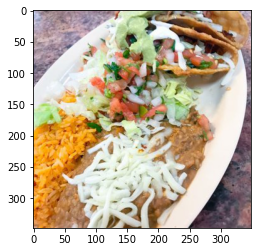

In [ ]:
img = plt.imread('drive/MyDrive/GA/datasets/yelp_set3/train/good/good1004.jpg')
print(img.shape)
plt.imshow(img);

(348, 348, 3)


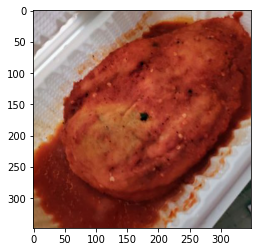

In [ ]:
img = plt.imread('drive/MyDrive/GA/datasets/yelp_set3/train/bad/bad1010.jpg')
print(img.shape)
plt.imshow(img);

# Load data using a Keras utility

The files are loaded form a Googel Drive into temporary Google Colab folder for analysis. `tf.keras.utils.image_dataset_from_directory` utility. This turns the folder of images into a `tf.data.Dataset`. You can learn more about loading your own data into tensorflow for modeling from scratch from tutorials found here: [Load and preprocess images](../load_data/images.ipynb).

## Create a dataset

Define some parameters for the loader:

In [3]:
batch_size = 16
img_height = 256
img_width = 256

Using all of the training set and 80% of the validation set.  This will allow setting aside some data for testing after validation in a future run.  In the next notebook (using transfer learning) validation and test data are used; using only 80% of the test data here allows both notebooks to have the same size validation sets. 

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory( 
  'drive/MyDrive/GA/datasets/yelp_set3/train',
  labels= 'inferred',
  class_names= ('bad','good'),
  shuffle= True,
  seed=123,

  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 960 files belonging to 2 classes.


In [5]:
train_ds.class_names[0]

'bad'

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'drive/MyDrive/GA/datasets/yelp_set3/val',
  labels= 'inferred',
  class_names= ('bad','good'),
  validation_split=0.8,
  subset="validation",
  shuffle= True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 452 files belonging to 2 classes.
Using 361 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [7]:
class_names = train_ds.class_names
print(class_names)

('bad', 'good')


## Visualize the data

Here are the second nine images from the training dataset. 

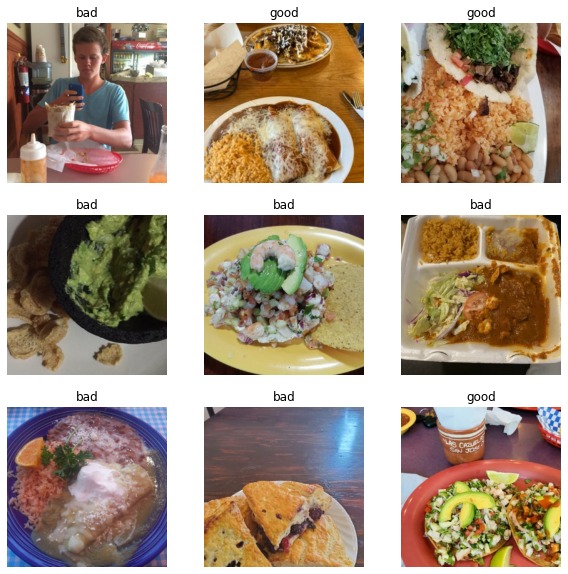

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
#You can save a copy using the code below:
#plt.savefig('drive/MyDrive/<FOLDER NAME HERE>/<IMAGE NAME HERE>.jpg', dpi=250, pad_inches=0.25)

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


The `image_batch` is a tensor of the shape `(16, 256, 256, 3)`. In otherwords it is a batch of 16 images of shape `180x180x3` (the last dimension (3) refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert either to a `numpy.ndarray`.

## Configure the dataset for performance

Below, `AUTOTUNE` is called using the `Dataset.cache` method.  This prevents i/o from becoming  a bottleneck by using a buffered prefetch of the data from the disk.  

Tensorflow's tutorial states the following:
- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

You can learn more about both methods and caching data to disk in the *Prefetching* section of their page: https://www.tensorflow.org/guide/data_performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

[a link to s2](#section2)


## Standardize the data

Color .jpg photos are stored in the RGB channel value range of 0 to 255.  Below, the data are standardized to floating decimal numbers between 0 and 1 to improve neural network computation using `tf.keras.layers.Rescaling`

In [ ]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer.  The latter method is used in this notebook.
- 1. You can apply it to the dataset by calling `Dataset.map` using the code below that is commented out.  
- 2. You can include the layer inside your model (this simplifies deployment).  

In [ ]:
# DON'T USE THIS CODE IF YOU CALL RESCALING IN YOUR MODEL DEFINITION IN THE NEXT STEP
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image)) 

Note: resizing can be accomplished using either the `image_size` argument of `tf.keras.utils.image_dataset_from_directory` as was done at the top and/or it can be included in the model using the `tf.keras.layers.Resizing` layer.

## Create the model

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This is a standard model this is used as a baseline to compare other models.

In [ ]:
model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid' )
])

In [ ]:
#Optionally save the model
# model_1.save('model_1')

## Compile the model

The `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function are used.  The former is a standard optimizer and the latter is correct loss function for binary classifications. By passing the `metrics` argument to `Model.compile`, training and validation accuracy for each training epoch are given.

In [ ]:
model_1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Model summary
View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

## Train the model
Best val_acc is about 76% after 5 of 10 ephochs.  This may vary slightly every time the model is run.

In [ ]:
epochs=10
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
60/60 [==============================] - 8s 42ms/step - loss: 0.7692 - accuracy: 0.5417 - val_loss: 0.6568 - val_accuracy: 0.5346
Epoch 2/10
60/60 [==============================] - 1s 17ms/step - loss: 0.5959 - accuracy: 0.6906 - val_loss: 0.4809 - val_accuracy: 0.7895
Epoch 3/10
60/60 [==============================] - 1s 17ms/step - loss: 0.4765 - accuracy: 0.7906 - val_loss: 0.4827 - val_accuracy: 0.7618
Epoch 4/10
60/60 [==============================] - 1s 17ms/step - loss: 0.3444 - accuracy: 0.8500 - val_loss: 0.5123 - val_accuracy: 0.7313
Epoch 5/10
60/60 [==============================] - 1s 17ms/step - loss: 0.2363 - accuracy: 0.9052 - val_loss: 0.8008 - val_accuracy: 0.6704
Epoch 6/10
60/60 [==============================] - 1s 17ms/step - loss: 0.1447 - accuracy: 0.9531 - val_loss: 0.7740 - val_accuracy: 0.6759
Epoch 7/10
60/60 [==============================] - 1s 17ms/step - loss: 0.0756 - accuracy: 0.9844 - val_loss: 1.0099 - val_accuracy: 0.6676
Epoch 8/10
60

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

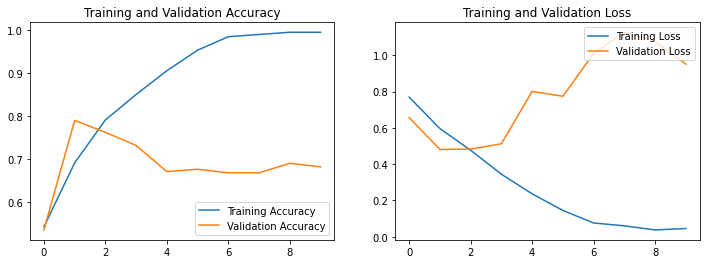

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('drive/MyDrive/Mar1/loss_acc_score_solo_Model_1.jpg',dpi=250, format='jpg')
plt.show()

The plots show that training accuracy and validation accuracy deviate after only a few epochs, with validation accuracy topping out at around 76%.

In the next model, additional parameters will be added to deal with the overfitting in the training set by introducing additional variation in a couple ways.  You can learn more about overfitting on tensorflow here: [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Data augmentation

Overfitting is a common problem in small training sets.  One way to counter this is by adding augmented images that are transformed in realistic permutations of the images, such as small rotations or flips.  This exposes the model to more aspects of each class.  
Data augmentation uses the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.  In this example, we use horizontal flip, 10% rotation, and 10% zoom.

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Here is what these augmentations looks like on one photo. You can rerun this block multiple times to see other examples.

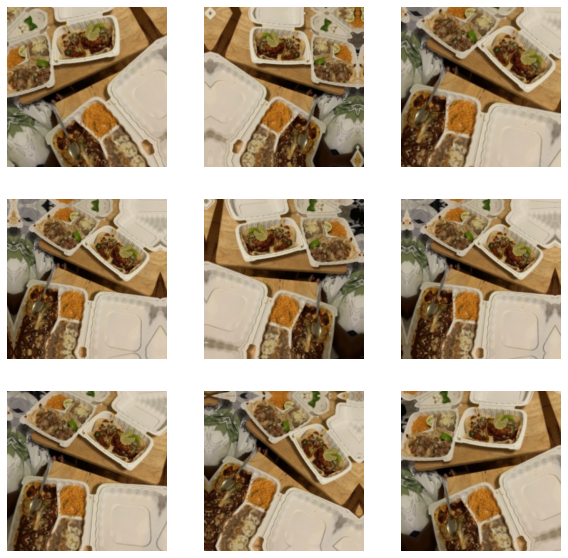

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.savefig('drive/MyDrive/Mar1/sm_model_2_augment_grid_1.jpg', dpi=250, format='jpg')

## Dropout

Overfitting can also be reduced using regularization techniques such as dropout.  Dropout randomly assigns a proportion of the output units (through the activation function) to zero during the training process.  Dropout is input as a decimal between 0 and 1, indicating the percent of output units to randomly drop in the applied layer.  

In [10]:
model2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

## Compile and train the model

In [11]:
model2.compile(optimizer='adam',
              loss='bce',
              metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
es= EarlyStopping( monitor= 'val_loss', patience= 20, verbose= 0, restore_best_weights= True)

Model 2 below shows improved accuracy compared to Model 1 above.  Accuracy jumps from the mid-70% to the mid-80% range in validation scores between the two.

In [ ]:
epochs = 20
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=es
)

In [ ]:
#Optionally save the model
model2.save('saved_model/model2')

## Visualize training results
The learning curves for Model 2 below show there is less overfitting compared to Model 1.  Image augmentation and applying dropout reduced overfitting and the train and val curves are now aligned closer.

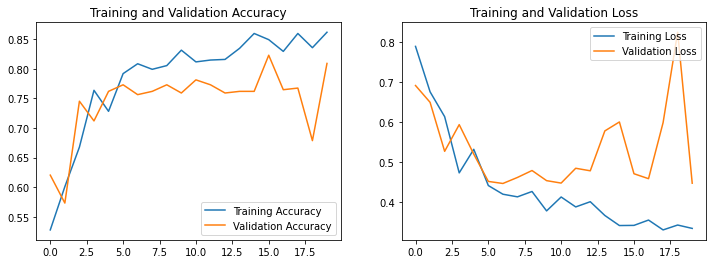

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('drive/MyDrive/Mar1/loss_acc_score_solo_Model_2.jpg',dpi=250, format='jpg')
plt.show()


## Reload Model 2 from Saved Model

In [ ]:
ls drive/MyDrive/Mar5/saved_model/model2

assets/  keras_metadata.pb  saved_model.pb  variables/


In [13]:
new_model = tf.keras.models.load_model('drive/MyDrive/Mar5/saved_model/model2')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                  

In [22]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  'drive/MyDrive/GA/datasets/yelp3_test',
  labels= None,
  shuffle= False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 1 classes.


In [23]:
predictions = new_model.predict(test_ds)

In [24]:
#np.set_printoptions(suppress=False)

In [25]:
predictions = np.round((predictions * 100))

In [64]:
predictions[0:5]

array([[30.],
       [ 0.],
       [90.],
       [71.],
       [12.]], dtype=float32)

In [27]:
score_list =[str(int(predictions)) for predictions in predictions]
score_list[0:5]

['30', '0', '90', '71', '12']

In [28]:
def zero_pad(list, n):
  temp_list = []
  for i in list:
    if len(i) == 1:
      temp_list.append(i.zfill(n))
    elif len(i) ==2:
      temp_list.append(i)
  return temp_list

In [29]:
padded_scores = zero_pad(score_list, 2)
padded_scores[0:5]

['30', '00', '90', '71', '12']

In [30]:
file_list= sorted(os.listdir('/content/drive/MyDrive/GA/datasets/yelp3_test'), reverse = False)

In [31]:
file_list[0:5]

['orig_sort00001.jpg',
 'orig_sort00002.jpg',
 'orig_sort00003.jpg',
 'orig_sort00004.jpg',
 'orig_sort00005.jpg']

In [32]:
# See if there are any extraneous files/folders in image folder
#ls drive/MyDrive/GA/datasets/yelp3_test/.ipynb_checkpoints

In [33]:
# remove any extraneous files/folders
#rm -rf drive/MyDrive/GA/datasets/yelp3_test/.ipynb_checkpoints

In [34]:
pwd

'/content'

In [41]:
from pathlib import Path
def append_id(filename,item):
        p = Path(filename)
        return p.rename("{2}_{0}{1}".format(p.stem, p.suffix, item))

In [ ]:
dictionary= dict(zip(file_list, padded_scores))
dictionary

In [44]:
cd drive/MyDrive/GA/datasets/yelp3_test

/content/drive/MyDrive/GA/datasets/yelp3_test


In [45]:
for (key,value) in dictionary.items():
      append_id(key, value)

In [46]:
cd ../../../../..

/content


In [47]:
# Making a list of the scored image
test_dir = '/content/drive/MyDrive/GA/datasets/yelp3_test'
scored_imgs = [fn for fn in os.listdir(test_dir) if fn.endswith('.jpg')]

In [65]:
# Sort the list by orginal Yelp gallery order
def last3digits(x):
  return(x[-7:-4])
         
imgs_org_sort = sorted(scored_imgs, key=last3digits)
imgs_org_sort[0:5]

['30_orig_sort00001.jpg',
 '00_orig_sort00002.jpg',
 '90_orig_sort00003.jpg',
 '71_orig_sort00004.jpg',
 '12_orig_sort00005.jpg']

In [49]:
# Making scores for labeling imgs
def first2digits(x):
  return(x[0:2]) 

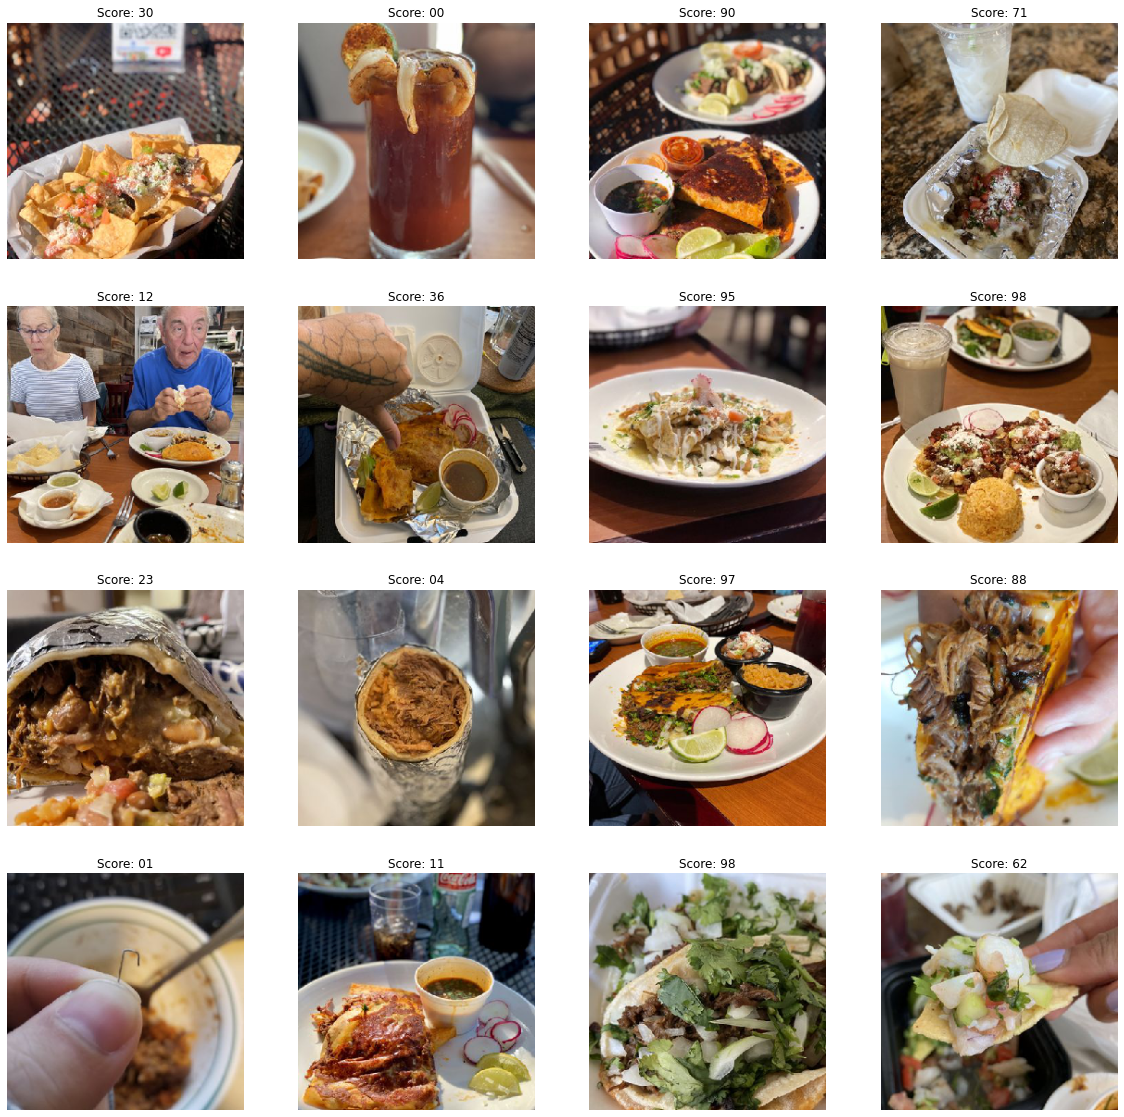

In [51]:
# Here is what the top of the Yelp gallery looked like originally (using food filter tab)
# Note some of the poor quality or non-food photos

fig = plt.figure(figsize= (20,20))

for i in range(16):
  
  fp = f'{test_dir}/{imgs_org_sort[i]}'
  label = "Score: " + first2digits(imgs_org_sort[i])
  ax = fig.add_subplot(4,4,i+1, aspect='equal')
  fn = image.load_img(fp,  target_size=(256,256),
                        color_mode='rgb')
  plt.imshow(fn, )
  plt.title(label)
  plt.axis('off')
  plt.savefig('drive/MyDrive/GA/proj_output/orginal_sort.jpg', dpi=180)

In [54]:
imgs_best_first= sorted(os.listdir('/content/drive/MyDrive/GA/datasets/yelp3_test'), reverse = True)
imgs_best_first[0:3]

['99_orig_sort00080.jpg', '98_orig_sort00093.jpg', '98_orig_sort00071.jpg']

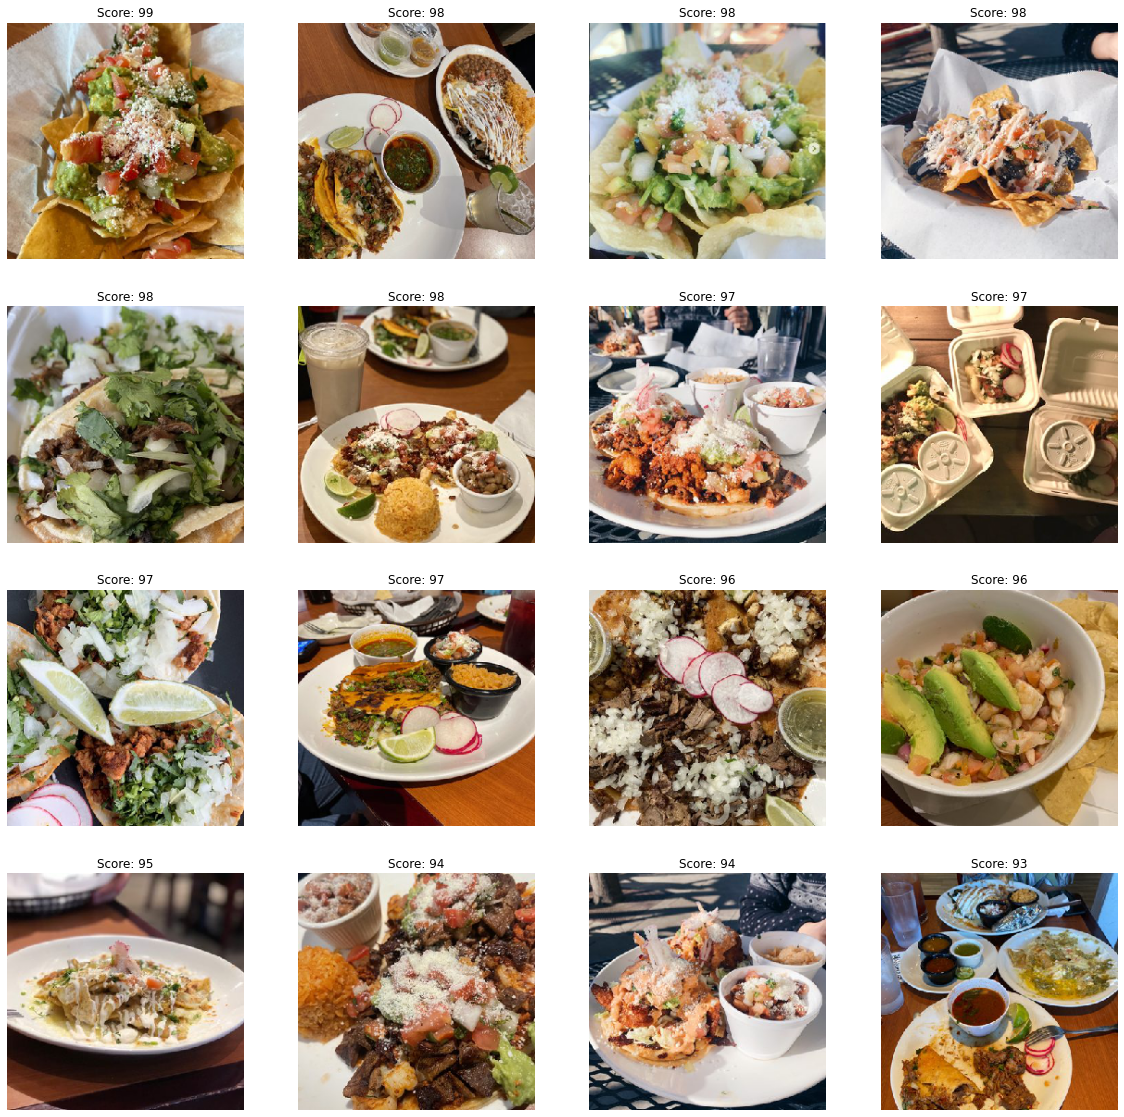

In [56]:
# Here are the top 20 images sorted by model score (best quality photos)
fig = plt.figure(figsize= (20,20))

for i in range(16):
  
  fp = f'{test_dir}/{imgs_best_first[i]}'
  label = "Score: " + first2digits(imgs_best_first[i])
  ax = fig.add_subplot(4,4,i+1, aspect='equal')
  fn = image.load_img(fp,  target_size=(256,256),
                        color_mode='rgb')
  plt.imshow(fn, )
  plt.title(label)
  plt.axis('off')
  plt.savefig('drive/MyDrive/GA/proj_output/best_20_model_sort.jpg', dpi=180)

In [59]:
imgs_worst_first= sorted(os.listdir('/content/drive/MyDrive/GA/datasets/yelp3_test'), reverse = False)
imgs_worst_first[10:14]

['00_orig_sort00077.jpg',
 '00_orig_sort00084.jpg',
 '01_orig_sort00013.jpg',
 '01_orig_sort00019.jpg']

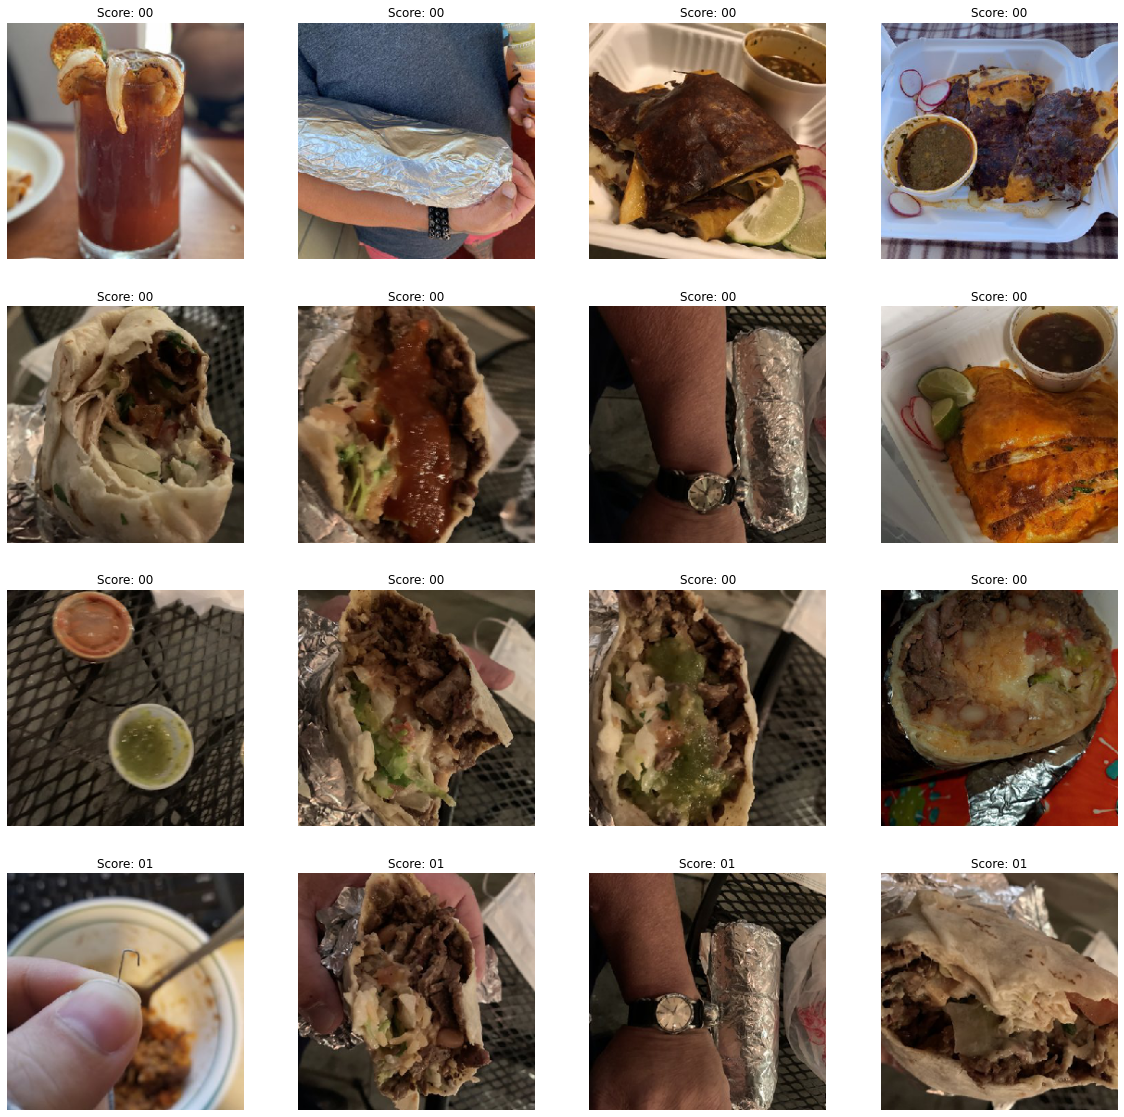

In [60]:
# For comparison, here are the bottom 20 images sorted by model score (worst photo quality)
fig = plt.figure(figsize= (20,20))

for i in range(16):
  
  fp = f'{test_dir}/{imgs_worst_first[i]}'
  label = "Score: " + first2digits(imgs_worst_first[i])
  ax = fig.add_subplot(4,4,i+1, aspect='equal')
  fn = image.load_img(fp,  target_size=(256,256),
                        color_mode='rgb')
  plt.imshow(fn, )
  plt.title(label)
  plt.axis('off')
  plt.savefig('drive/MyDrive/GA/proj_output/worst_20_model_sort.jpg', dpi=180)

## Predict On A Single New Image

Below, a new image not in the original data is selected to test.  Note that data augmentation and dropout layers are inactive during inference mode.

In [134]:
# The input image can be either a local path or a web URL.  
# Remove one of the pound signs below to see how it works

# new_pic_url = 'https://s3-media0.fl.yelpcdn.com/bphoto/a8JCRnbB9ijlxVeLB6Nx0g/258s.jpg'
# new_pic_url = 'https://s3-media0.fl.yelpcdn.com/bphoto/biC5FK0-pMTLg8wKHVHwDg/258s.jpg'
# new_pic_url = 'https://s3-media0.fl.yelpcdn.com/bphoto/iFlhH37N_EbiqNfukt_67g/258s.jpg'
# new_pic_url = 'https://s3-media0.fl.yelpcdn.com/bphoto/XmHBfZUhjWJ4Oy_iMyDYOA/258s.jpg'
# new_pic_url = '/Users/<your_user_name>/<example_folder>/<example_file>.jpg'

# Or past the path of a local file you have:
new_pic = 'drive/MyDrive/GA/datasets/yelp3_test/28_orig_sort00090.jpg'


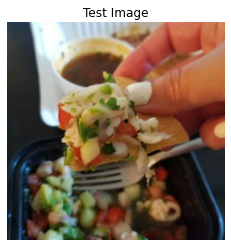

In [135]:
# Use this for loading from a directory path
#new_pic = tf.keras.utils.load_img(new_pic, target_size=(img_height, img_width))
img = plt.imread(new_pic);
#print(img.shape)
plt.axis('off')
plt.title("Test Image")
plt.imshow(img);

# # use this for loading from a URL
# new_pic = tf.keras.utils.get_file('Test Image', origin=new_pic_url);
# img = plt.imread(new_pic);
# #print(img.shape)
# plt.axis('off')
# plt.title("Test Image")
# plt.imshow(img);

In [136]:
img = tf.keras.utils.load_img(new_pic, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

pred_for_img = new_model.predict(img_array)
score = (pred_for_img[0])
if score < 0.5:
  print("This image is predicted to be classified as 'Bad' or (low quality) photo with {:.0f} percent confidence."
    .format(100-(100 * np.max(score))))
elif score >= 0.5:
  print("This image is predicted to be classified as 'Good' or (high quality) photo with {:.0f} percent confidence."
    .format(100 * np.max(score)))

This image is predicted to be classified as 'Bad' or (low quality) photo with 60 percent confidence.


'/content'

In [ ]:
from pathlib import Path

def append_id(filename):
    path = Path(filename)
    return path.with_stem(f"{test1}_{my_pred}")